# Documentación del Script: Data Preprocessing, Metrics, and Association Analysis

**Autor:** Garikoitz Artola Obando 

**Fecha:** 09/11/2025

Este notebook documenta y ejemplifica las funciones principales del script `process_data.py`.

## Librerías y Dependencias
- `numpy`
- `pandas`
- `matplotlib`

Instalación de dependencias:
```
pip install numpy pandas matplotlib
```

## Cargar librerias

In [1]:
import numpy as np
import pandas as pd

## Cargar funciones

In [2]:
from process_data import *

## 1. Funciones de Discretización
Las funciones transforman variables numéricas en variables categóricas mediante discretización.

### `discretizeEW(x, num_bin)`
- **Entrada:**
  - `x`: arreglo numérico a discretizar
  - `num_bin`: número de bins
- **Salida:** Diccionario con `factor` (variable categórica) y `cut_points` (puntos de corte)

### `discretizeEF(x, num_bin)`
- **Entrada:**
  - `x`: arreglo numérico a discretizar
  - `num_bin`: número de bins de igual frecuencia
- **Salida:** Diccionario con `factor` y `cut_points`

### Ejemplo de Uso:

In [3]:
from process_data import dis_attribute, dis_dataset

data = np.array([1,2,3,4,5,6,7,8,9,10])
discrete_ew = dis_attribute(data, num_bin=3, mode=False)  # Equal-width
discrete_ef = dis_attribute(data, num_bin=3, mode=True)   # Equal-frequency
discrete_df = dis_dataset(pd.DataFrame({'A': data, 'B': data*2}), num_bin=3)
print(discrete_ew)
print(discrete_ef)
print(discrete_df)

{'factor': [[-inf, 4.0), [-inf, 4.0), [-inf, 4.0), [4.0, 7.0), [4.0, 7.0), [4.0, 7.0), [7.0, inf), [7.0, inf), [7.0, inf), [7.0, inf)]
Categories (3, interval[float64, left]): [[-inf, 4.0) < [4.0, 7.0) < [7.0, inf)], 'cut_points': array([4., 7.])}
{'factor': [[-inf, 5.0), [-inf, 5.0), [-inf, 5.0), [-inf, 5.0), [5.0, 8.0), [5.0, 8.0), [5.0, 8.0), [8.0, inf), [8.0, inf), [8.0, inf)]
Categories (3, interval[float64, left]): [[-inf, 5.0) < [5.0, 8.0) < [8.0, inf)], 'cut_points': array([5, 8])}
             A            B
0  [-inf, 4.0)  [-inf, 8.0)
1  [-inf, 4.0)  [-inf, 8.0)
2  [-inf, 4.0)  [-inf, 8.0)
3   [4.0, 7.0)  [8.0, 14.0)
4   [4.0, 7.0)  [8.0, 14.0)
5   [4.0, 7.0)  [8.0, 14.0)
6   [7.0, inf)  [14.0, inf)
7   [7.0, inf)  [14.0, inf)
8   [7.0, inf)  [14.0, inf)
9   [7.0, inf)  [14.0, inf)


## 2. Funciones de Métricas
La función calcula métricas para los atributos de un dataset: varianza y AUC para las variables contínuas y entropía para las discretas.

### `metrics_dataset(dataset, class.var = NULL, discretize_for_auc = FALSE, bins = 10, verbose = FALSE)`

- **Entrada:** dataset, variable de clase opcional
- **Salida:** data.frame con columnas: variable, type, variance, entropy, auc
- **Descripción interna:** Calcula métricas según tipo de variable


### Ejemplo de Uso:

In [4]:
from process_data import metrics_dataset

df = pd.DataFrame({
    'num': [1,2,3,4,5],
    'num_con': np.random.randn(5),
    'cat': np.random.choice(list("abcd"), 5),
    'class': np.random.choice([0,1], 5)
})
metrics_df = metrics_dataset(df, class_var='class')
print(metrics_df)

  variable         type  variance   entropy   auc
0      num      numeric  2.500000       NaN  0.25
1  num_con      numeric  0.261997       NaN  0.50
2      cat  categorical       NaN  1.370951   NaN


## 3. Normalización y Estandarización
Funciones para escalar datos numéricos.

### `normalize_vector(v)` y `standardize_vector(v)`
- **Entrada:** Vector `v`
- **Salida:** Vector normalizado/estandarizado
- **Comentario interno:** Se manejan valores NaN, se calcula min/max o media/desviación

### `normalize_dataset(df)` y `standardize_dataset(df)`
- **Entrada:** DataFrame `df`
- **Salida:** DataFrame con columnas numéricas normalizadas o estandarizadas
- **Comentario interno:** Se aplica la función a cada columna numérica

### Ejemplo de Uso:

In [5]:
from process_data import normalize_dataset, standardize_dataset

df_norm = normalize_dataset(df)
df_std = standardize_dataset(df)
print(df_norm)
print(df_std)

    num   num_con cat  class
0  0.00  0.423190   b    0.0
1  0.25  1.000000   c    0.0
2  0.50  0.530902   c    0.0
3  0.75  0.780367   d    1.0
4  1.00  0.000000   c    1.0
        num   num_con cat     class
0 -1.414214 -0.364947   b -0.816497
1 -0.707107  1.336764   c -0.816497
2  0.000000 -0.047174   c -0.816497
3  0.707107  0.688801   d  1.224745
4  1.414214 -1.613445   c  1.224745


## 4. Filtrado de Variables por Métrica
La función filtra las variables en base a las métricas implementadas. Esto es, devuelve un nuevo dataset, donde todas las variables cumplan los requisitos indicados.

### `filter_by_metric(dataset, metric, threshold, class_var=None)`
- **Entrada:** DataFrame, nombre de la métrica ('entropy', 'variance', 'auc'), umbral y opcional variable de clase
- **Salida:** DataFrame filtrado
- **Comentario interno:** Se calcula la métrica correspondiente y se filtran variables que cumplen el umbral

### Ejemplo de Uso:

In [6]:
from process_data import filter_by_metric

filtered_df = filter_by_metric(df, metric='entropy', threshold=0.5)
print(filtered_df)

  cat
0   b
1   c
2   c
3   d
4   c


## 5. Matriz de Asociación por Pares

La función calcula la correlación (información mutua en el caso de variables categóricas) por pares entre variables de un dataset.

### `pairwise_assoc_matrix(dataset, num_bin=10, normalize_mi=True, mode=False)`
- **Entrada:** DataFrame `dataset`, número de bins, normalización MI, modo de discretización
- **Salida:** Matriz de asociación
- **Comentario interno:** Se discretizan columnas numéricas y se calcula Pearson para num-num y MI para demás combinaciones

### Ejemplo de Uso:

In [7]:
from process_data import pairwise_assoc_matrix

assoc_mat = pairwise_assoc_matrix(df)
print(assoc_mat)

              num   num_con       cat     class
num      1.000000 -0.444764  0.768399  0.866025
num_con -0.444764  1.000000  0.768399 -0.377484
cat      0.768399  0.768399  1.000000  0.364009
class    0.866025 -0.377484  0.364009  1.000000


## 6. Funciones de Plotting

Funciones para plotear el AUC y para las matrices de correlación/información mutua.

### `plot_auc(metrics_df)`

* **Entrada:** data.frame con columnas `auc`
* **Salida:** gráfico de barras mostrando AUC
* **Descripción interna:** Ordena variables por AUC y añade línea de referencia

### `plot_assoc_matrix(mat)`

* **Entrada:** matriz de asociación
* **Salida:** heatmap usando matplotlib
* **Descripción interna:** Paleta azul-blanco-rojo, filas y columnas etiquetadas

### Ejemplo de Uso:

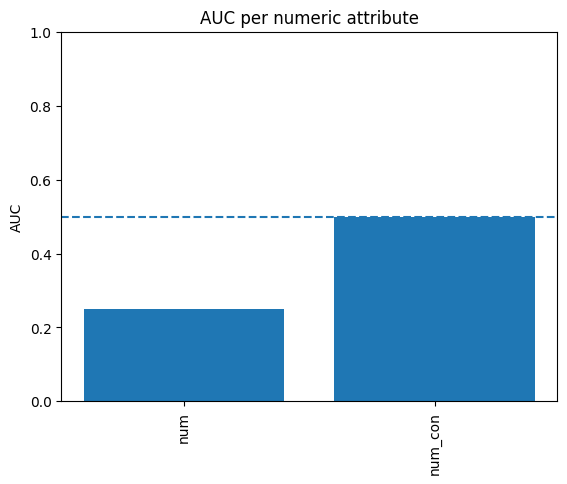

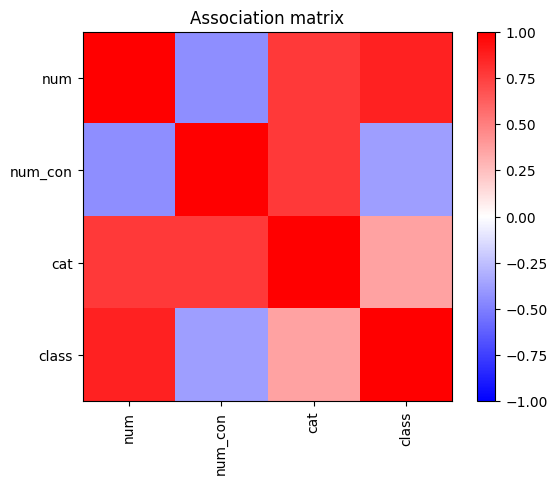

In [8]:
from process_data import plot_auc, plot_assoc_matrix

plot_auc(metrics_df)
plot_assoc_matrix(assoc_mat)